In [1]:
import matplotlib.pyplot as plt
import torch

from src.data_modules.segmentation_data_module import \
    CbisDdsmDataModuleSegmentation
from src.models.segmentation_model import SegmentationModel

/home/kristof/VITMMB10/mammo-vision/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datamodule = CbisDdsmDataModuleSegmentation(
    root_dir="data/cbis-ddsm-segme",
    tumor_type="mass",
    batch_size=1,
    num_workers=4,
)

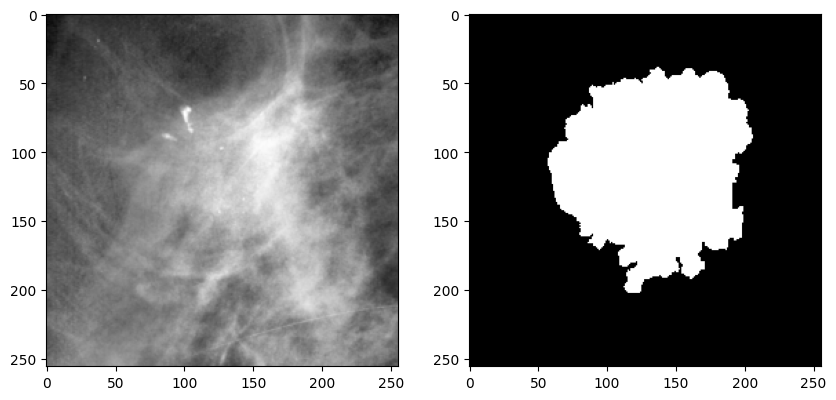

In [3]:
for batch in datamodule.train_dataloader():
    x, y = batch
    x = x[0]

    image = torch.squeeze(x).numpy()
    mask = y

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap="gray")
    axes[1].imshow(torch.squeeze(torch.argmax(mask, dim=1)), cmap="gray")

    plt.show()
    break

In [4]:
checkpoint = "models/mass-segmentation.ckpt"
print(torch.load(checkpoint, map_location="cpu"))
model = SegmentationModel.load_from_checkpoint(checkpoint, map_location="cpu")
model = model.eval()

{'epoch': 5, 'global_step': 4884, 'pytorch-lightning_version': '2.5.1', 'state_dict': OrderedDict({'model.model.0.conv.weight': tensor([[[[-0.2243,  0.1375, -0.1216],
          [ 0.3770,  0.0739, -0.2027],
          [ 0.2590, -0.2379,  0.1007]]],


        [[[ 0.3509,  0.2356, -0.0192],
          [-0.2082,  0.1401,  0.0869],
          [ 0.1561, -0.2627, -0.3743]]],


        [[[-0.2940, -0.3037, -0.0952],
          [ 0.1695,  0.0709,  0.2477],
          [ 0.1256, -0.2066,  0.2771]]],


        [[[-0.1350,  0.2673, -0.1342],
          [-0.3217, -0.2394,  0.2307],
          [ 0.1439, -0.3471,  0.1532]]],


        [[[-0.1632,  0.1899, -0.2697],
          [ 0.0546,  0.1586, -0.0761],
          [-0.3076,  0.1798,  0.0834]]],


        [[[ 0.1075,  0.2724,  0.2509],
          [-0.1751,  0.1890, -0.0274],
          [-0.0330, -0.1204, -0.3493]]],


        [[[ 0.3673, -0.1006,  0.0335],
          [ 0.0824,  0.2791, -0.1774],
          [ 0.1141, -0.0682, -0.1145]]],


        [[[-0.2679,  0.28

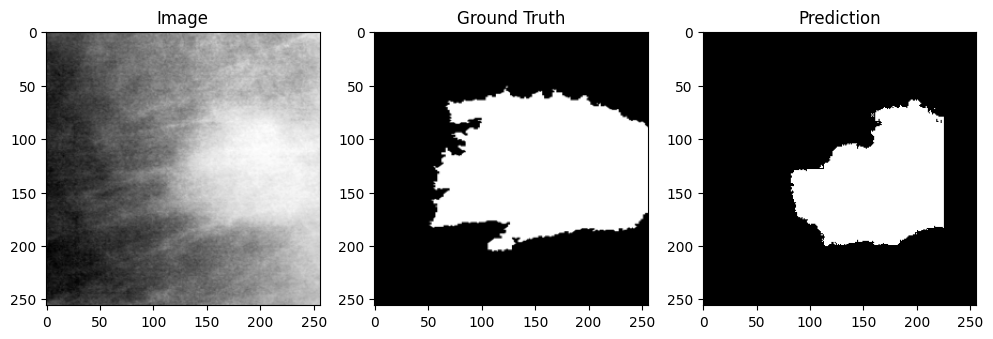

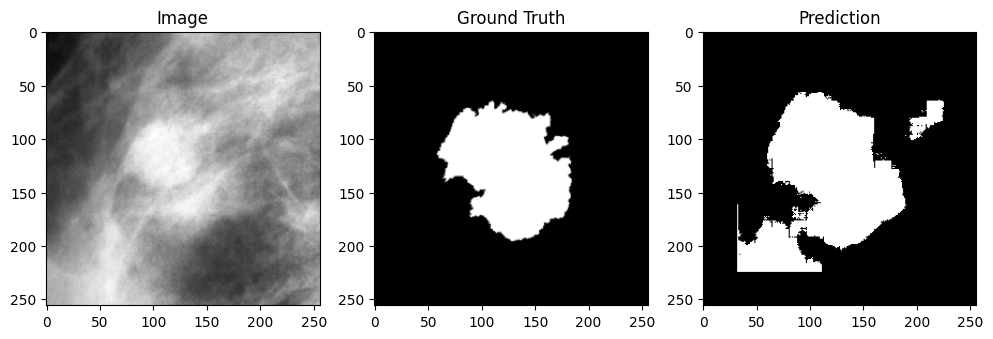

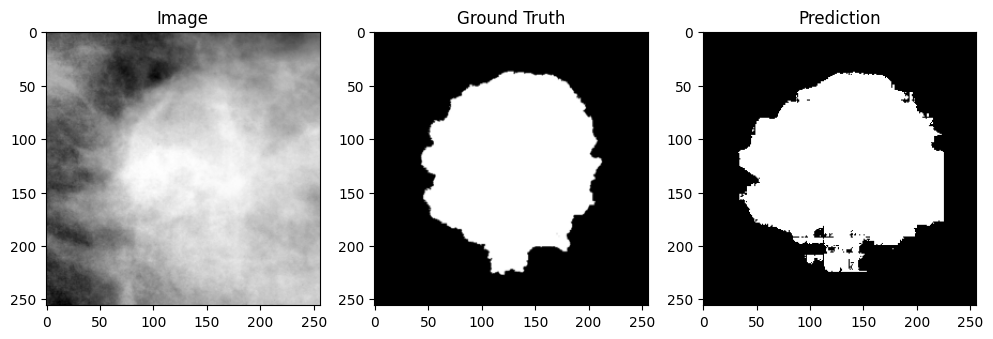

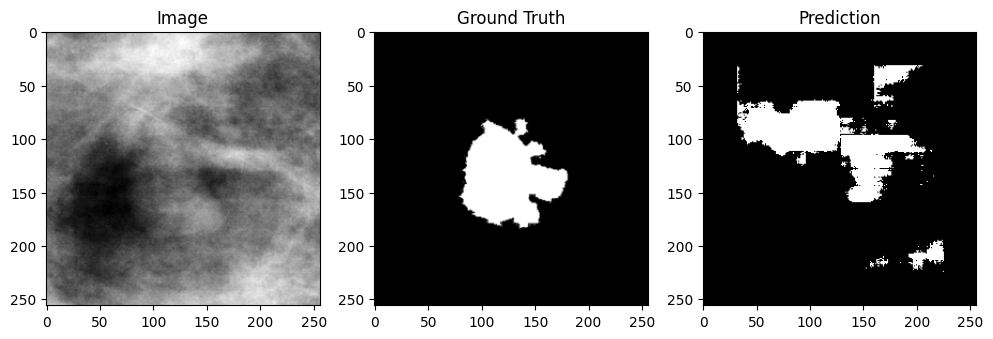

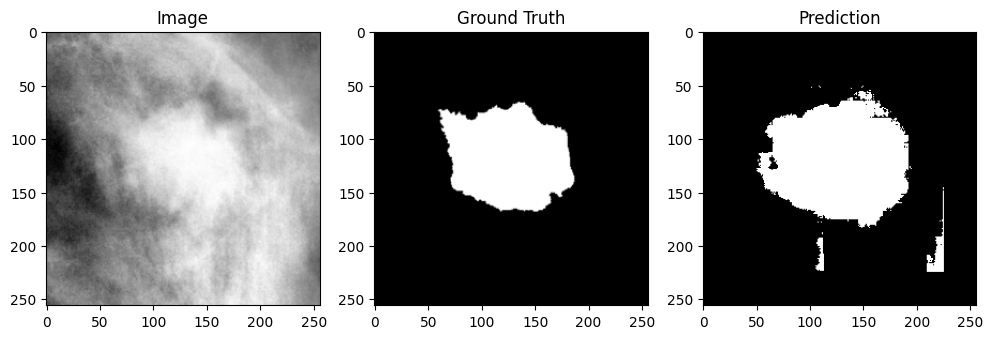

In [5]:
for idx, batch in enumerate(datamodule.val_dataloader()):
    if idx == 25:
        break

    if idx % 5 != 0:
        continue

    x, y = batch

    # Get model predictions
    with torch.no_grad():
        prediction = model(x.to(model.device))

    prediction = torch.argmax(prediction, dim=1)
    prediction = torch.squeeze(prediction).numpy()

    # Plot results
    image = torch.squeeze(x).numpy()
    mask = torch.squeeze(y).numpy()
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Image")
    axes[1].imshow(mask[1], cmap="gray")
    axes[1].set_title("Ground Truth")
    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Prediction")
    plt.show()

In [6]:
import monai.losses
import torch

model.eval()
with torch.no_grad():
    outputs = model(x)

cross_entropy = torch.nn.CrossEntropyLoss()
ce_loss = cross_entropy(outputs, y)
print("Cross Entorpy:", ce_loss.item())

dice_loss = monai.losses.DiceLoss(softmax=True)
d_loss = dice_loss(outputs, y)
print("Dice Loss:", d_loss.item())

print("Total Loss:", (ce_loss + d_loss).item())

Cross Entorpy: 0.1551135778427124
Dice Loss: 0.17795833945274353
Total Loss: 0.33307191729545593


In [7]:
from monai.metrics import DiceMetric

dice_metric = DiceMetric(reduction="mean_batch")

# Ensure model is in evaluation mode
model.eval()

# Get model predictions
with torch.no_grad():
    outputs = model(x)

# Convert to binary mask
predictions = torch.argmax(outputs, dim=1).unsqueeze(1)
ground_truth = torch.argmax(y, dim=1).unsqueeze(1)

print("Predictions shape:", predictions.shape)
print("Ground Truth shape:", ground_truth.shape)

# Compute Dice score
dice_score = dice_metric(y_pred=predictions, y=ground_truth)

print("Dice Score:", dice_score)

Predictions shape: torch.Size([1, 1, 256, 256])
Ground Truth shape: torch.Size([1, 1, 256, 256])
Dice Score: tensor([[0.8218]])
